In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../src')
from clean_text import text_preprocessing_pipeline
from transformers import AutoTokenizer, AutoModel
model_name = 'roberta-base'

In [5]:
df = pd.read_csv(os.getcwd() + '/../data/perfect_dataset.csv')
df.head()

,old_tag,title_x,artist_x,text,views,processed_artist,processed_title,tag,artist_y,title_y,processed title,artist_title
0,rock,Bring Me to Life,Evanescence,[Verse 1: Amy Lee]\nHow can you see into my ey...,658884,evanescence,bringmetolife,metal,Evanescence,Bring Me To Life,bringmetolife,evanescencebringmetolife
1,rock,My Immortal,Evanescence,[Verse 1]\nI'm so tired of being here\nSuppres...,392209,evanescence,myimmortal,metal,Evanescence,My Immortal,myimmortal,evanescencemyimmortal
2,rock,Zombie,Bad Wolves,[Verse 1]\nAnother head hangs lowly\nChild is ...,342157,badwolves,zombie,metal,Bad Wolves,Zombie,zombie,badwolveszombie
3,rock,A Little Piece of Heaven,Avenged Sevenfold,[Verse 1: M. Shadows]\nBefore the story begins...,259796,avengedsevenfold,alittlepieceofheaven,metal,Avenged Sevenfold,A Little Piece of Heaven,alittlepieceofheaven,avengedsevenfoldalittlepieceofheaven
4,rock,Doomsday,Architects,[Verse 1]\nRemember when Hell had frozen over?...,217795,architects,doomsday,metal,Architects,Doomsday,doomsday,architectsdoomsday


In [6]:
# # leave only 5000 the most viewed rows in each tag
# df = df.groupby('tag').apply(lambda x: x.nlargest(10000, 'views')).reset_index(drop=True)
# df.head()

In [7]:
df.shape

(175000, 12)

In [8]:
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [9]:
df.tag.value_counts()

tag
rb       7084
pop      7078
rap      6956
rock     6952
metal    6930
Name: count, dtype: int64

In [10]:
# leave only text and tag columns
df = df[['text', 'tag']]
df.head()

,text,tag
0,[Instrumental intro 0:00-1:03]\n\n[Chorus]\nWi...,rock
1,"Brother, Brother\nHelp me please\nI'm as lonel...",rock
2,"[Intro: Howard Hewett, Monty Seward]\nYou know...",rb
3,Gazing at the stars\nWe're flying over million...,metal
4,"Timeless we are, timeless we are\nChildren run...",metal


In [11]:
# clean the text
df['text'] = df['text'].apply(text_preprocessing_pipeline)
df.head()

/home/john/DataspellProjects/AnalyzingLyricsByAI/ml/../src/clean_text.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


,text,tag
0,Will you and your friend come around Are you a...,rock
1,"Brother , Brother Help me please I'm as lonely...",rock
2,"You know , Mont' , man , I've been thinking I ...",rb
3,Gazing at the stars We're flying over million ...,metal
4,"Timeless we are , timeless we are Children run...",metal


In [12]:
# get distinct tags
target_cols = df['tag'].unique()
target_cols

array(['rock', 'rb', 'metal', 'rap', 'pop'], dtype=object)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
label = encoder.fit_transform(df[['tag']]).toarray()
# append one hot encoded label to the dataframe with distinct tags as columns
df = pd.concat([df, pd.DataFrame(label, columns=target_cols)], axis=1)
df.head()

,text,tag,rock,rb,metal,rap,pop
0,Will you and your friend come around Are you a...,rock,0.0,0.0,0.0,0.0,1.0
1,"Brother , Brother Help me please I'm as lonely...",rock,0.0,0.0,0.0,0.0,1.0
2,"You know , Mont' , man , I've been thinking I ...",rb,0.0,0.0,0.0,1.0,0.0
3,Gazing at the stars We're flying over million ...,metal,1.0,0.0,0.0,0.0,0.0
4,"Timeless we are , timeless we are Children run...",metal,1.0,0.0,0.0,0.0,0.0


In [14]:
# split the data into training and validation
df.drop(columns=['tag'], inplace=True)
# reset the index
df.reset_index(drop=True, inplace=True)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_val.shape

((28000, 6), (7000, 6))

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [16]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 1
LEARNING_RATE = 1e-5
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [18]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_val, tokenizer, MAX_LEN)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l1 = torch.nn.Linear(768, 256)
        self.fc = torch.nn.Linear(768,5)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        #features = F.relu(self.l1(features))
        # output_2 = self.l2(output_1)
        output = F.softmax(self.fc(features), dim=1)
        return output


In [19]:
model = BERTClass()
model.to(device);

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [21]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [24]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%40 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}, processed: {_/len(train_loader)*100}%')
            
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [23]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  1.61452317237854, processed: 0.0%
Epoch: 0, Loss:  1.4731566905975342, processed: 1.8281535648994516%
Epoch: 0, Loss:  1.3687974214553833, processed: 3.656307129798903%
Epoch: 0, Loss:  1.4304747581481934, processed: 5.484460694698354%
Epoch: 0, Loss:  1.3212275505065918, processed: 7.312614259597806%
Epoch: 0, Loss:  1.423586368560791, processed: 9.140767824497258%
Epoch: 0, Loss:  1.316751480102539, processed: 10.968921389396709%
Epoch: 0, Loss:  1.3756523132324219, processed: 12.79707495429616%
Epoch: 0, Loss:  1.4027636051177979, processed: 14.625228519195613%
Epoch: 0, Loss:  1.3191922903060913, processed: 16.453382084095065%
Epoch: 0, Loss:  1.3306267261505127, processed: 18.281535648994517%
Epoch: 0, Loss:  1.313887357711792, processed: 20.109689213893965%
Epoch: 0, Loss:  1.2775206565856934, processed: 21.937842778793417%
Epoch: 0, Loss:  1.2635624408721924, processed: 23.76599634369287%
Epoch: 0, Loss:  1.2965726852416992, processed: 25.59414990859232%
Epoch: 


KeyboardInterrupt



In [24]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [25]:
from sklearn import metrics

outputs, targets = validation()
outputs_decoded = np.argmax(outputs, axis=1)
targets_decoded = np.argmax(targets, axis=1)
accuracy = metrics.accuracy_score(targets_decoded, outputs_decoded)
f1_score_micro = metrics.f1_score(targets_decoded, outputs_decoded, average='micro')
f1_score_macro = metrics.f1_score(targets_decoded, outputs_decoded, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7477142857142857
F1 Score (Micro) = 0.7477142857142857
F1 Score (Macro) = 0.7446549560302985


In [74]:
print(classification_report(targets_decoded, outputs_decoded, target_names=target_cols))

              precision    recall  f1-score   support

       metal       0.87      0.90      0.88      2037
         pop       0.71      0.73      0.72      1996
         rap       0.84      0.87      0.85      1993
          rb       0.82      0.64      0.72      2004
        rock       0.73      0.81      0.77      1970

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [61]:
torch.save(model.state_dict(), 'model.bin')

## Load the model

In [23]:
model = BERTClass()
model.load_state_dict(torch.load(os.getcwd() + '/../model/model4.bin'))
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
from sklearn.metrics import confusion_matrix

# outputs, target = validation()

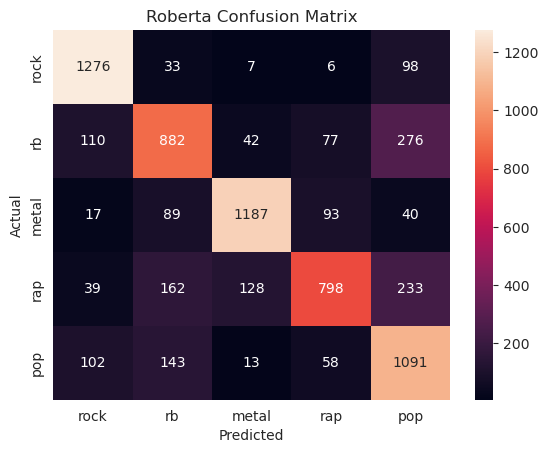

In [29]:
cm = confusion_matrix(targets_decoded,outputs_decoded)

sns.heatmap(cm,
    annot=True,
    fmt='g',
    xticklabels=target_cols,
    yticklabels=target_cols,
    )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Confusion Matrix')
plt.savefig(os.getcwd() + '/../eda/roberta_cm.png')

In [30]:
def predict(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)
    outputs = model(ids, mask, token_type_ids)
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs

In [33]:
text = '''When marimba rhythms start to play
Dance with me, make me sway
Like a lazy ocean hugs the shore
Hold me close, sway me more
Like a flower bending in the breeze
Bend with me, sway with ease
When we dance you have a way with me
Stay with me, sway with me
Other dancers may be on the floor
Dear, but my eyes will see only you
Only you have that magic technique
When we sway I go weak- Через финальную модель прогоню тексты и получу векторы, наложу PCA, построю графики 
I can hear the sounds of violins
Long before it begins
Make me thrill as only you know how
Sway me smooth, sway me now
Other dancers may be on the floor
Dear, but my eyes will see only you
Only you have that magic technique
When we sway I grow weak
I can hear the sounds of violins
Long before it begins
Make me thrill as only you know how
Sway me smooth, sway me now
When marimba rhythms start to play
Dance with me, make me sway
Like a lazy ocean hugs the shore
Hold me close, sway me more
Like a flower bending in the breeze
Bend with me, sway with ease
When we dance you have a way with me
Stay with me, sway with me
When marimba start to play
Hold me close, make me sway
Like a ocean hugs the shore
Hold me close, sway me more
Like a flower bending in the breeze
Bend with me, sway with ease
When we dance you have a way with me
Stay with me, sway with me'''

In [34]:
outputs = predict(text)
outputs_max = np.argmax(outputs)
target_cols[outputs_max]


'rb'

In [ ]:
# test = df_val.iloc[:10]

In [ ]:
# i = 2

In [ ]:
# test.iloc[i].text

In [ ]:
# test.iloc[i]

In [ ]:
# for text in test.text:
#     outputs = predict(text)
#     outputs_max = np.argmax(outputs)
#     tag = target_cols[outputs_max]
#     print(outputs)
#     print(f"Predicted Tag: {tag}")
#     print()
